# TF hub modules used for feature extraction:
https://tfhub.dev/google/bit/m-r101x1/1

In [ ]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import tensorflow_hub as hub

import tensorflow as tf # tf.__version__ 
import tensorflow.keras as keras 
import matplotlib.pyplot as plt # for making plots, 
import scipy.stats as stats  # library for statistics and technical programming, 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageDraw
from IPython.display import display
from tensorflow.keras import backend as K # used for housekeeping of tf models,

In [2]:
# setup paths 
os.chdir('/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution/notebooks') 
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)
print(basedir)

# caution, loaded only form basedir, 
from src.utils.example_plots import *
from src.utils.image_augmentation import *
from src.utils.feature_extraction_tools import encode_images_with_tfhubmodule # with tf.compat.v1 functions, for tf.__version___ >= 1.15

/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution


# Step 1. Small EDA on all available pictures, and classes
---

OBSERVATIONS:   
* avaiable datasets are relatively small, (50-280 pictures)   
* some classses, like van and truck have pictutres of similar vehicles, that may be problematic wiht    insufficient training data.   


CONCLUSION:     
* I will create two datasets to train my models,    
    * one, only with pictures procided in swissroads datasset   
    * second with the same pictures augmented, with different color, shifts, diffent saturation, added noise, rotations etc...

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


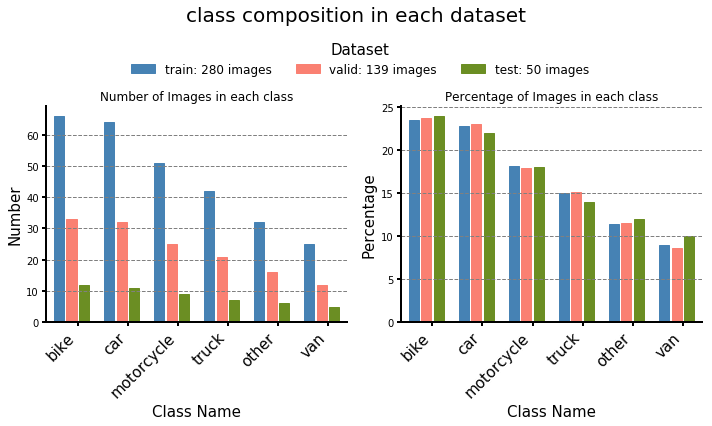

train, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


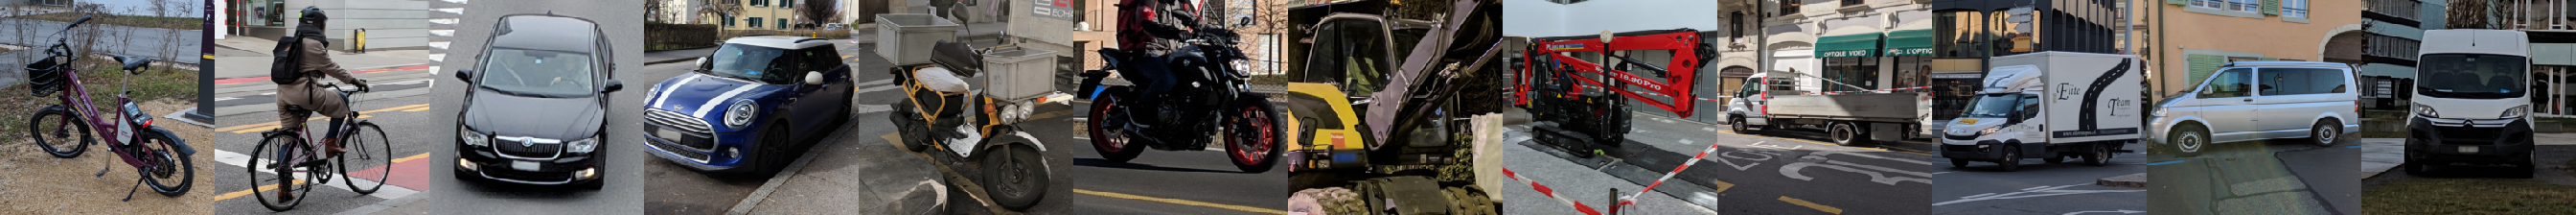

valid, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


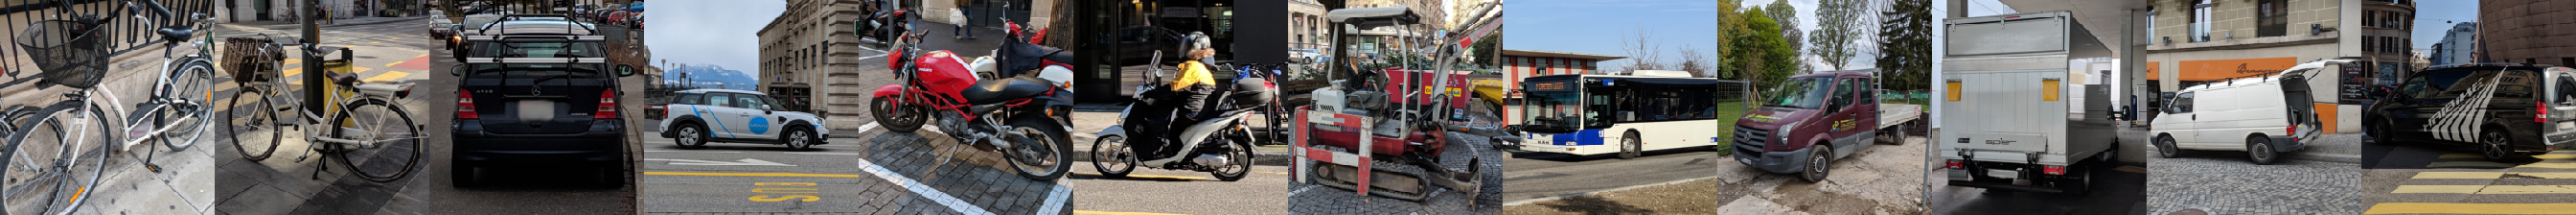

test, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


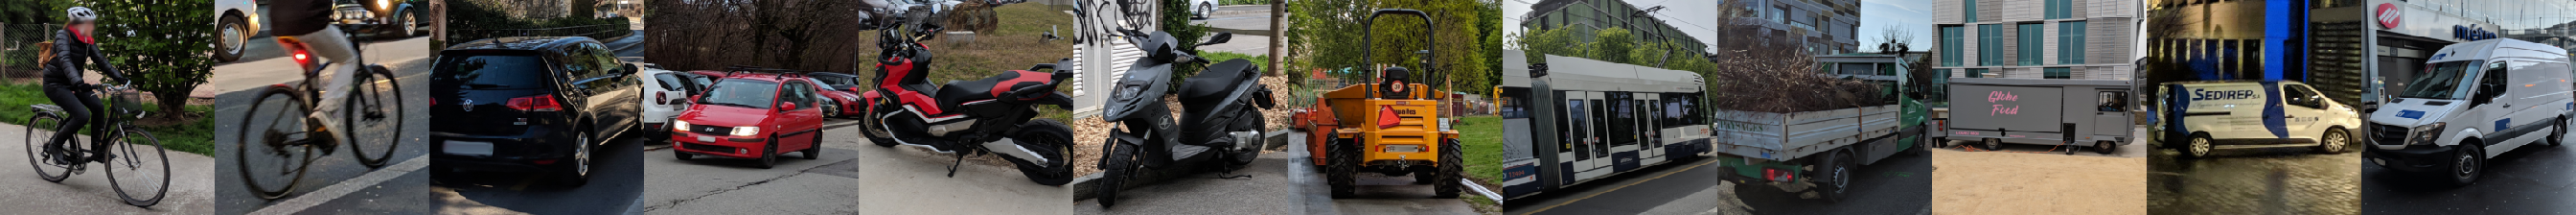

In [3]:
# Creat Image generator, just to sample the pictures easily,  
simple_generator = ImageDataGenerator()

# collect iterators for each datatype in swissroads, 
iterators_dct = dict()
datasetnames = ["train", "valid", "test"]
for setname in datasetnames:    
    iterators_dct[setname] = simple_generator.flow_from_directory(
        os.path.join(basedir, "data/raw/swissroads/", setname),
        batch_size=10000, # it will use only max available pictures,  
        target_size=(224, 224), 
        shuffle=False     # here I use generator only to explote the data
    )

    
# compare numbers and percatenate of images in different classes between datastes
barplot_with_class_composition(generator_dct=iterators_dct, 
                               title="class composition in each dataset", figsize=(10,6))

# Examine Class composition in train datasest in more detail
# piechart_with_class_composition(generator=iterators_dct["train"], title=f"{setname} dataset\n", figsize=(5,2))
        
    
# Plot two examples of each class from each dataset, 
for setname in datasetnames:
    #print(f"{''.join(['.']*80)}\n{setname} dataset\n{''.join(['.']*80)}")
    display(plot_example_images_using_generator(iterators_dct[setname], title=setname, pixel_size=224, class_n_examples=2))

# Step 2. Create augmented images and save then in data/interim folder as augmented_swissroads
---

In [14]:
# ....................................................................................
# Create Augmented Images

# datatype in swissroads, 
datasetnames = ["train", "valid", "test"]

# create generator to sample all images in each datasets in one batch, 
iterators_dct = dict()
simple_generator = ImageDataGenerator()
for setname in datasetnames:    
    iterators_dct[setname] = simple_generator.flow_from_directory(
        os.path.join(basedir, "data/raw/swissroads/", setname),
        batch_size=10000,          # it will use only max available pictures,  
        target_size=(224, 224),    # used by mobilenet_v2 cnn layer, 
        shuffle=False              # here I use generator only to explote the data
    )

# Create image augmentation policy, 
augconfig = dict(
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    rotation_range=30,
    brightness_range=[0.2,1.8], 
    zoom_range=[0.5,1.5],
    channel_shift_range=0.2)


# Create augmented images, for each dataset, 
train_batch_img_aug, train_filename = create_augmented_images(external_generator=iterators_dct["train"],augm_img_nr=2, paramsforgenerator=augconfig)
print(f"train, batch size: {train_batch_img_aug.shape[0]}")
valid_batch_img_aug, valid_filename = create_augmented_images(external_generator=iterators_dct["valid"],augm_img_nr=2, paramsforgenerator=augconfig)
print(f"valid, batch size: {valid_batch_img_aug.shape[0]}")
test_batch_img_aug, test_filename = create_augmented_images(external_generator=iterators_dct["test"],augm_img_nr=0)
print(f"test, batch size: {test_batch_img_aug.shape[0]}")

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


KeyboardInterrupt: 

In [ ]:
# ....................................................................................
# Plot Examples of Augmented Images

imgages_to_display = 3
for imgnr in [0, 100,150, 200, 270]:
    # 
    oneingname = train_filename.imgname.unique()[imgnr]
    idx = train_filename.loc[(train_filename.imgname==oneingname),:].index.values.tolist()
    img_arr = train_batch_img_aug[idx]

    # plot some examples, 
    plt.style.use('classic')
    fig, axs = plt.subplots(ncols=imgages_to_display, nrows=1, figsize=(5,2.5), facecolor="white")
    fig.suptitle(oneingname, fontsize=20)
    for i, ax in enumerate(axs.flat):
        # get one augmented figure, and convert it to integers for viewing
        img = np.array(img_arr[i], dtype=np.float32)/255 # plot raw pixel data, [0-1]
        if i==0: ax.set_title("raw image")
        else:    ax.set_title("augmented")   
        ax.imshow(img)    
        ax.set(xticks=[], yticks=[])
    fig.subplots_adjust(top=0.75)
    plt.tight_layout()
    plt.show(); 

In [72]:
# ....................................................................................
# Save Augmented Images in new directory as png, 

save_augmented_images(
    datasetname="train", 
    img_batch=train_batch_img_aug, 
    batch_info=train_filename, 
    savedir=os.path.join(basedir, "data/interim/augmented_swissroads"), 
    verbose=True)

save_augmented_images(
    datasetname="test", 
    img_batch=test_batch_img_aug, 
    batch_info=test_filename, 
    savedir=os.path.join(basedir, "data/interim/augmented_swissroads"), 
    verbose=True)

save_augmented_images(
    datasetname="valid", 
    img_batch=valid_batch_img_aug, 
    batch_info=valid_filename, 
    savedir=os.path.join(basedir, "data/interim/augmented_swissroads"), 
    verbose=True)


840 images were saved
in /Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution/data/interim/augmented_swissroads
in following files for each classe: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']
50 images were saved
in /Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution/data/interim/augmented_swissroads
in following files for each classe: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']
417 images were saved
in /Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution/data/interim/augmented_swissroads
in following files for each classe: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


# Control augmented datasset
---

Found 840 images belonging to 6 classes.
Found 417 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


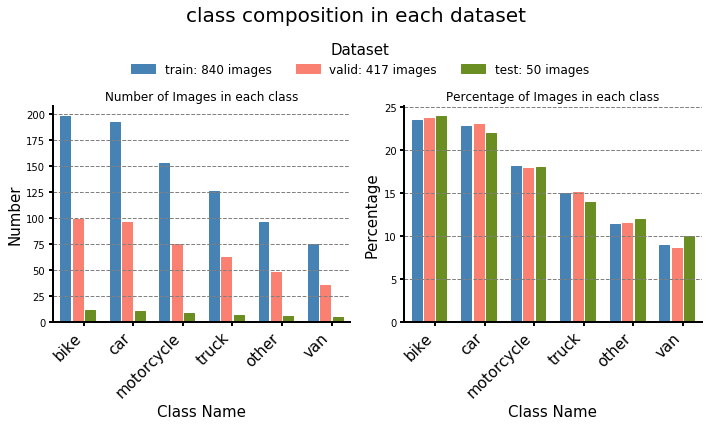

train, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


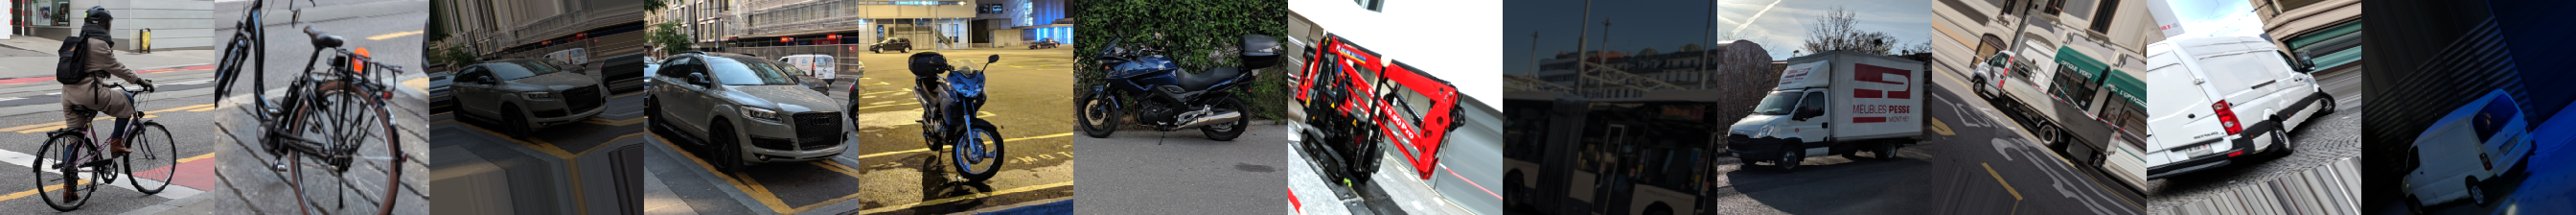

valid, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


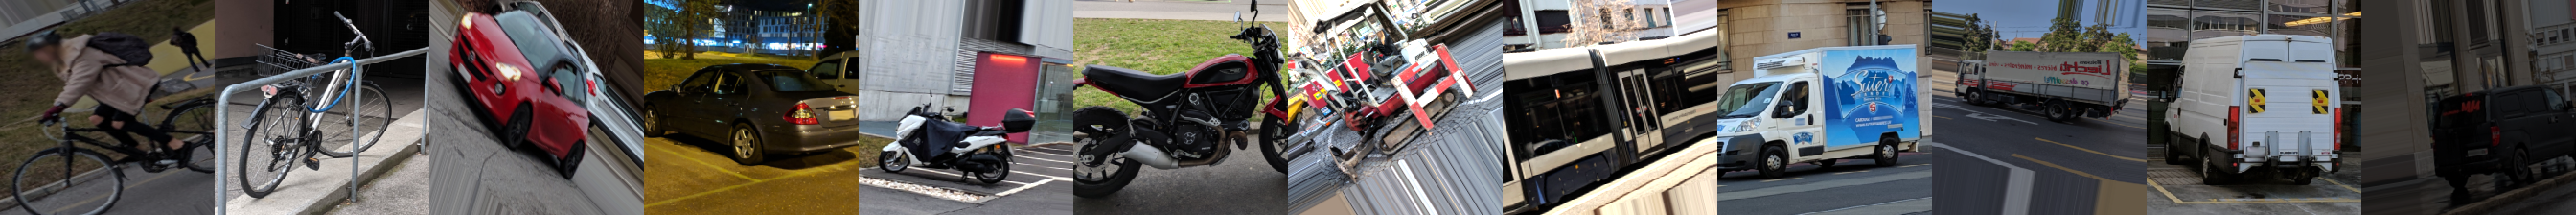

test, Classes: ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']


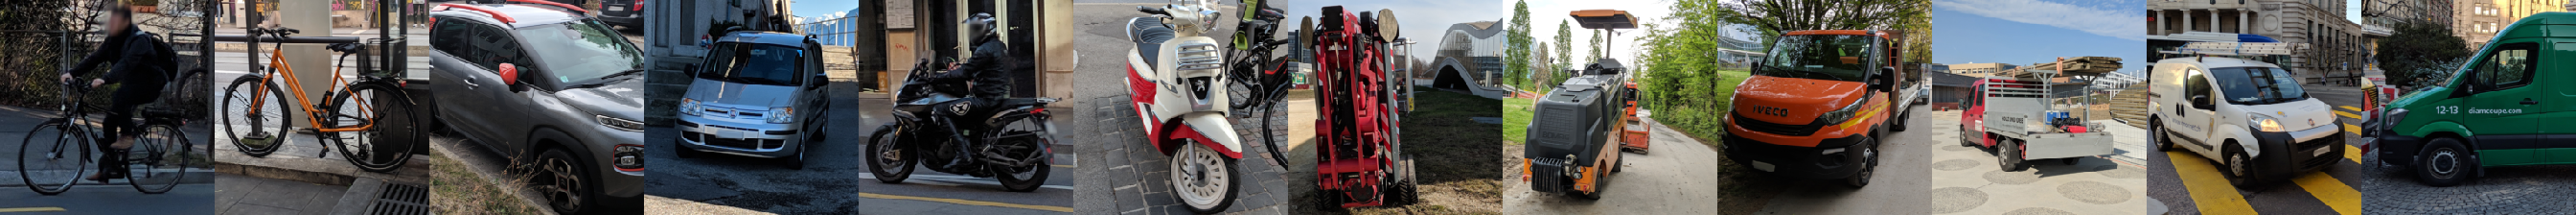

In [6]:
# ....................................................................................
# Test whther everything is ok, with saved images, 

# Creat Image generator, just to sample the pictures easily,  
simple_generator = ImageDataGenerator()

# collect iterators for each datatype in swissroads, 
iterators_dct = dict()
datasetnames = ["train", "valid", "test"]
for setname in datasetnames:    
    iterators_dct[setname] = simple_generator.flow_from_directory(
        os.path.join(basedir, "data/interim/augmented_swissroads/", setname),
        batch_size=10000, # it will use only max available pictures,  
        target_size=(224, 224), 
        shuffle=False     # here I use generator only to explote the data
    )

    
# compare numbers and percatenate of images in different classes between datastes
barplot_with_class_composition(generator_dct=iterators_dct, 
                               title="class composition in each dataset", figsize=(10,6))

# Plot two examples of each class from each dataset, 
for setname in datasetnames:
    display(plot_example_images_using_generator(iterators_dct[setname], title=setname, pixel_size=224, class_n_examples=2))

# Step 3. Extract high level features form all images, 
---
* for each dataset: train, test, and valid, I prepared the following:
    * npy array with extracted features, 
      (one row == one image)
    * csv file with info on each image
      ( original name, whther it is augmented or not, dataset and class it belongs to)
 
* and logfile i csv format
    * that contains files names of the above array/csv files created for each dataset,
    * number of images in eacgh dataset
    * datetime, when the files were created/moddiffied for the last time,

In [ ]:
# parameters
module_names = ["mobilenet", "imagenet", "resnet", "resnet_two"]
module_paths = ["imagenet_mobilenet_v2_100_224_feature_vector_2", "imagenet_inception_v3_feature_vector_3", "bit_m-r101x1_1", "resnet_50_feature_vector_1"]
img_imput_size = [(224, 224), (299, 299), (224, 224), (224, 224)]

# paths and dataset names, 
path_to_dataset = os.path.join(basedir, "data/interim/augmented_swissroads/")
path_to_save_encoded_files = path_to_dataset
data_subset_names = ["train","valid","test"]

# encode,  
for m_name, m_path, m_in_size in zip(module_names, module_paths, img_imput_size):
    
    print(f"Ecoding:,{m_name}, {m_path}, {m_in_size}")
    
    # run, 
    encodedimageges_dct, lables_dct = encode_images_with_tfhubmodule( 
                datasetname="augmented_swissroads", 
                module_name=m_name, 
                module_location=os.path.join(basedir,"models", m_path), 
                load_dir = path_to_dataset, 
                folders_in_load_dir=data_subset_names, 
                save_dir = path_to_save_encoded_files,
                img_target_size=m_in_size,                     
                save_files=True,
                verbose=False
        )

class_examples